### The model story

1. Data Exploration (Train Data)
2. Data Preprocessing and cleansing
3. Feature engineering/selection
4. Model bulding and evaluation
5. Test the model tarined without description embeddings (PCAs) on Test Data
6. Test the model tarined with description embeddings (PCAs) on Test Data
7. Benchmarking
   

In [2]:
import pandas as pd
import numpy as np
import os
import sys

    ### For sentiment analysis
from transformers import AutoTokenizer, AutoModel

    ### For working with strings, timing, file saving/loading
import re
import time
import pickle
import joblib

    ### For visualizations
import matplotlib.pyplot as plt

    ### For feature reduction
from sklearn.decomposition import PCA

    ### Necessary preprocessings and machine learning models
from sklearn.model_selection import train_test_split
    # To encode categorical variables
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
    # Required performance metrics
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

    ### We need to see all columns
pd.set_option('display.max_columns', None)
import warnings

    # First set the absolute path to the project root (for proper imports)
sys.path.append(os.path.abspath(".."))
    # All utility functions are in utils
import src.utils as utils

    # Also, get the project root path (one level up from dev_and_run folder) to navigate through other folders like data
project_root = os.path.abspath("..")


### 1. Data Exploration (Train Data)

In [3]:
file_path = os.path.join(project_root, "data/")
data_df = pd.read_csv(file_path + 'train.csv')
data_df.head(10)

,user_id,date,description,debit,credit,is_payroll
0,0,5/19/2022,Insurance Payment 635-87-8182,74.30,0.00,False
1,0,5/22/2022,ETransfer 749-55-7590,200.65,0.00,False
2,0,5/30/2022,Interest Payment 052-77-0907,51.57,0.00,False
3,0,6/2/2022,Gas 095-02-5678,6.33,0.00,False
4,0,6/10/2022,Shopping 020-99-8785,129.43,0.00,False
5,0,6/15/2022,Groceries 089-30-5207,36.96,0.00,False
6,0,6/26/2022,Utility Bill 765-89-9510,312.53,0.00,False
7,0,7/11/2022,ATM Withdrawal 764-97-6524,62.01,0.00,False
8,0,7/22/2022,Coffee Purchase 515-39-9176,0.00,48.33,False
9,0,7/25/2022,Phone Bill 353-81-3853,152.06,0.00,False


In [29]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356876 entries, 0 to 356875
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      356876 non-null  int64  
 1   date         356876 non-null  object 
 2   description  356876 non-null  object 
 3   debit        356876 non-null  float64
 4   credit       356876 non-null  float64
 5   is_payroll   356876 non-null  bool   
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 14.0+ MB


In [30]:
data_df.describe()

,user_id,debit,credit
count,356876.000000,356876.000000,356876.000000
mean,1390.792197,78.042650,189.206644
std,805.670168,100.317797,1515.891826
min,0.000000,0.000000,0.000000
25%,691.000000,3.530000,0.000000
50%,1392.000000,43.960000,0.000000
75%,2097.000000,113.692500,0.000000
max,2786.000000,10417.710000,225163.880000


In [31]:
### This is why the 1st, 2nd and 3rd quantiles of credit are all zero (majority of records have a credit = 0)
len(data_df[data_df.credit == 0])

277377

<Axes: ylabel='Frequency'>

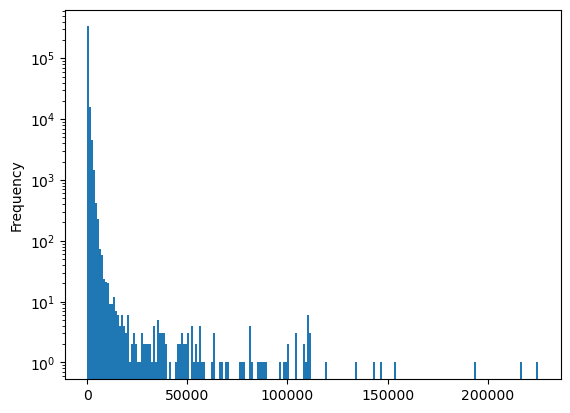

In [32]:
### To get an idea about the distribution of credit values and number and range of its outliers
data_df.credit.plot(kind = 'hist', bins = 226, log = True)

<Axes: ylabel='Frequency'>

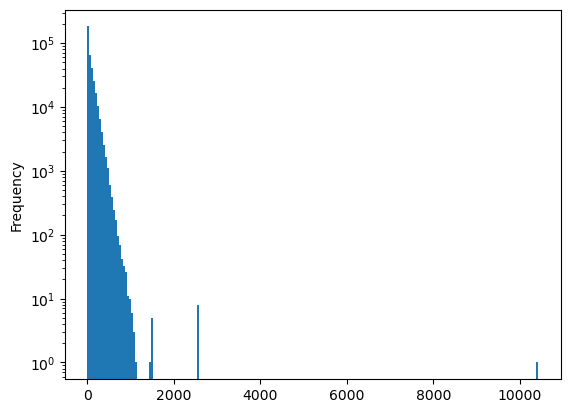

In [33]:
### Also, let's see how is the distibution of debit values and number and range of its outliers
data_df.debit.plot(kind = 'hist', bins = 226, log = True)

In [34]:
### If we assume 10,000 as the threshold for payroll (as an unusual amount), what percent of payrolls will be above it?  
### The ratio of records labeled as payroll with an amount > 10,000 to the total payroll labels
len(data_df[(data_df.is_payroll == True) & (data_df.credit > 10000)]) / len(data_df[data_df.is_payroll == True])

0.004429678848283499

<Axes: ylabel='Frequency'>

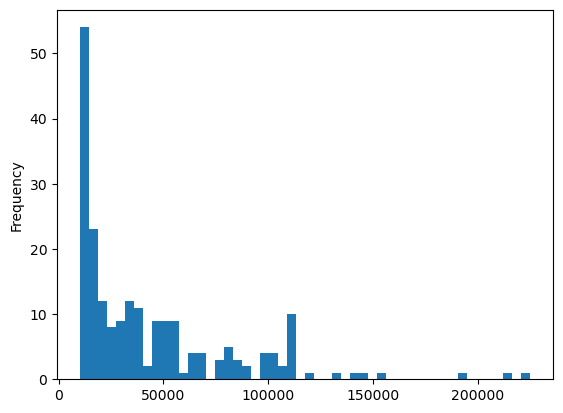

In [35]:
### This will give us a closer view of distribution of payrolls > 10,000
data_df[data_df['credit'] > 10000].credit.plot(kind= 'hist', bins = 50)

In [36]:
### We also wonder how frequent are such high-credits (credit outliers) in payroll and if they are regularly
### happening for the same users

payroll_num = []
unique_id_num = []
for credit in range(5000, 115000, 10000):
    payroll_num.append(len(data_df[(data_df['credit'] > credit) & (data_df.is_payroll == True)]))
    unique_id_num.append(data_df[(data_df['credit'] > credit) & (data_df.is_payroll == True)].user_id.nunique())
outliers = pd.DataFrame(list(zip(list(range(5000, 115000, 10000)), payroll_num, unique_id_num)), \
                        columns = ['credit > than', 'payroll_num', 'unique_id_num'])
outliers

,credit > than,payroll_num,unique_id_num
0,5000,604,160
1,15000,151,7
2,25000,114,5
3,35000,95,5
4,45000,77,5
5,55000,56,4
6,65000,45,4
7,75000,41,3
8,85000,32,3
9,95000,28,2


In [37]:
### It is good to know what is the rate of payroll
len(data_df[data_df.is_payroll == True]) / len(data_df)

0.1315751129243771

In [ ]:
### Conclusion on data exploration:

# 1. There is no missing value
# 2. A variable like date needs to be converted to more meaningful variables
# 3. Outliers of debit and credit need to be handled
# 4. Credit outliers (assuming 10,000 as the threshold) labeled as payroll has only a rate of ~.44% of total payrolls
# 5. payroll outliers are mostly assigned to few users (have a recurrent nature)
# 6. Descriptions have a unique-looking tailing number. This needs further analysis.
# 7. Descriptions contain meaningful content that can be exploited by our predictive model.
# 8. There is a moderate class imbalance in the data (class 1 is about 13% of observations)


### 2. Data Preprocessing and cleansing

#### 1.1 Handelling outliers:

We found out that a considerable number of high-credits are labeled as is_payroll and the majority of them are regularly happening for a handful of users. Without a thorough field knowledge and investigation we can't say if we need to put a limit on credit value for payrolls. But we need to scale them appropriately. As both debit and specially credit have a 'power law'-like distribution, we will do a log scaling (only on non-zero values) to reduce the harmful effect of outliers on our linear models.


In [4]:
data_df['debit_scaled'] = data_df.debit.apply(lambda x: np.log(x) if x > 0 else 0)
data_df['credit_scaled'] = data_df.credit.apply(lambda x: np.log(x) if x > 0 else 0)

In [39]:
data_df.describe()

,user_id,debit,credit,debit_scaled,credit_scaled
count,356876.000000,356876.000000,356876.000000,356876.000000,356876.000000
mean,1390.792197,78.042650,189.206644,3.130544,1.255418
std,805.670168,100.317797,1515.891826,2.022585,2.482438
min,0.000000,0.000000,0.000000,-4.605170,-4.605170
25%,691.000000,3.530000,0.000000,1.261298,0.000000
50%,1392.000000,43.960000,0.000000,3.783280,0.000000
75%,2097.000000,113.692500,0.000000,4.733497,0.000000
max,2786.000000,10417.710000,225163.880000,9.251263,12.324584


#### 2.2 Handeling wrongly labeled payrolls:

There is no record with any missing value, so we can't discard any payroll for lack of data. However, one thing that we know is that a transaction can't be a debit and a credit at the same time. Let's see if there are such transactions and remove them from our data.


In [40]:
### Every transaction can be only either debit or credit, not both!

data_df[(data_df.debit > 0) & (data_df.credit > 0)]

,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled
22757,178,4/17/2023,TERIANET PAY TIIC _VR,1.00,195.02,True,0.000000,5.273102
24094,190,7/2/2022,IRQ CODDE DZE PAUIE,10417.71,194.97,True,9.251263,5.272846
52354,403,4/17/2023,KURBRA wEZ PAY p_V,10.13,195.03,True,2.315501,5.273153
91646,709,3/15/2023,GBPay vxia mXen shzi furj,20.03,194.92,True,2.997231,5.272589
91647,709,3/15/2023,GBPay vxia mXen shzi furj,10.02,194.95,True,2.304583,5.272743
...,...,...,...,...,...,...,...,...
296443,2320,4/15/2023,"Pay BurZns, EKim land LeeX",192.74,195.00,True,5.261342,5.273000
305581,2390,4/17/2023,TERIANET PAY TIIC _VR,1.00,194.93,True,0.000000,5.272641
308330,2411,1/30/2023,Goluv dTu Cjanada IGov ofF CanGada,100.00,195.00,True,4.605170,5.273000
308349,2411,2/28/2023,Goluv dTu Cjanada IGov ofF CanGada,100.00,194.93,True,4.605170,5.272641


In [7]:
### Now, let's remove the wrongly labled records
data_df, wrongly_labelled = utils.remove_wrongly_labelled_data(data_df)
print(f"{len(wrongly_labelled)} records where removed for being wrongly labelled.")

76 records where removed for being wrongly labelled.


In [45]:
### Finally, we need to make sure the credit value has no data leakage, i.e., whether only payrolls have a nonzero credit.
### The below result shows that majority of credit > 0 are payrolls, so, it is a strong predictor though is not exclusive. 

share_of_payroll_of_nonzero_credit = len(data_df[(data_df.credit > 0) & (data_df.is_payroll == True)]) / len(data_df[data_df.credit > 0])
print(f"{share_of_payroll_of_nonzero_credit * 100:.2f}% of nonzero credits are labelled as payroll.")

59.03% of nonzero credits are labelled as payroll.


### 3. Feature engineering/selection

### 3.1 Convert date to more meaningful variables

Payrolls often happen at specific times like near the middle and/or end of month, weekdays, and in the 3rd and/or last week
of the month. Also, dates can vary due to month length (28, 30, or 31 days). Thus, it's helpful to introduce additional features that
capture a more consistent payroll pattern, as mentioned above. We'll also extract month of year as a new variable as it can add
further sequence information to our data. These new features will help our model handle cases where payroll lands near the middle
or end of month regardless of the exact date.    

In [47]:
data_df = utils.add_date_info(data_df)
data_df.head(5)


,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled,day_of_month,day_of_week,week_of_month,month_of_year
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,False,4.308111,0.0,19,4,3,5
1,0,2022-05-22,ETransfer 749-55-7590,200.65,0.0,False,5.301562,0.0,22,7,4,5
2,0,2022-05-30,Interest Payment 052-77-0907,51.57,0.0,False,3.942940,0.0,30,1,5,5
3,0,2022-06-02,Gas 095-02-5678,6.33,0.0,False,1.845300,0.0,2,4,1,6
4,0,2022-06-10,Shopping 020-99-8785,129.43,0.0,False,4.863140,0.0,10,5,2,6


In [48]:
### 3.2 Create interpretable variables from description

### To make descriptions interpretable for machine we need to convert them to embeddings (numerical arrays)

### This is the number of unique raw descriptions
data_df.description.apply(lambda x: x.lower()).nunique()

315523

3.2.1 Trim descriptions from unnecessary and useless transaction numbers

The above number of unique descriptions, which is near the total number of records, is due to the tailing transaction numbers
that exist in the majority of descriptions. They all have the same format of "ddd-dd-dddd". We first will remove them all.

In [50]:
    # List to store extracted transaction numbers
trans_numbers = []

 # Function to remove trailing transaction numbers and store them in a variable
def prune_trans_number(description, trans_numbers):
    
        # Find transaction numbers with the format "123-43-2850" at the end of the string
    match = re.search(r'\b\d{3}-\d{2}-\d{4}$', description)
    if match:
        trans_numbers.append(match.group())  # Store the found transaction number
            # Remove the transaction number from the description
        return re.sub(r'\b\d{3}-\d{2}-\d{4}$', '', description).strip()
    
    return description
    
    # We'll add a new column for the trimmed description because we need the original one for further analysis later 
data_df['description_trimmed'] = data_df['description'].apply(prune_trans_number)

    # Here we check to make sure that our guess about the unique nature of transaction numbers is true.  
unique_trans_numbers = set(trans_numbers)
print(f"Total and unique transaction numbers found: {len(trans_numbers), len(unique_trans_numbers)}")


Total and unique transaction numbers found: (309920, 309860)


In [51]:
### As we see from above the total and unique number of transaction numbers are almost the same. So, they are unique numbers. There 
### are only 60 duplicate transaction numbers but this is very small and deciding about them needs more field knowledge and scrutiny. 

data_df.head(7)

,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled,day_of_month,day_of_week,week_of_month,month_of_year,description_trimmed
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,False,4.308111,0.0,19,4,3,5,Insurance Payment
1,0,2022-05-22,ETransfer 749-55-7590,200.65,0.0,False,5.301562,0.0,22,7,4,5,ETransfer
2,0,2022-05-30,Interest Payment 052-77-0907,51.57,0.0,False,3.942940,0.0,30,1,5,5,Interest Payment
3,0,2022-06-02,Gas 095-02-5678,6.33,0.0,False,1.845300,0.0,2,4,1,6,Gas
4,0,2022-06-10,Shopping 020-99-8785,129.43,0.0,False,4.863140,0.0,10,5,2,6,Shopping
5,0,2022-06-15,Groceries 089-30-5207,36.96,0.0,False,3.609836,0.0,15,3,3,6,Groceries
6,0,2022-06-26,Utility Bill 765-89-9510,312.53,0.0,False,5.744700,0.0,26,7,4,6,Utility Bill


In [52]:
### Let's see how many unique description do we have now (after trimming)

data_df.description_trimmed.apply(lambda x: x.lower()).nunique()

5627

In [53]:
### Well, that is very good and makes sense. It is much more efficient to create embeddings from them now. But, when we checked out
### the payroll descriptions for having transaction numbers we found something interesting.

payroll_unique = data_df[data_df.is_payroll == True].description.apply(lambda x: x.lower()).nunique()
payroll_trimmed_unique = data_df[data_df.is_payroll == True].description_trimmed.apply(lambda x: x.lower()).nunique()

print("The number of payrolls with a transaction number before and after trimming are: ")
print(f"Before trimming = {payroll_unique}")
print(f"After trimming = {payroll_trimmed_unique}")

The number of payrolls with a transaction number before and after trimming are: 
Before trimming = 5607
After trimming = 5607


That means:

1. all payrolls have a lean description (no tailing number)
2. non-payrolls altogether are described under only 5627 - 5607 = 20 unique descriptions (if trimmed of transaction numbers)
3. we know that only 13% of transactions are a payroll but more than 99.5% of different descriptions belong to them. Thus, a careful
classification of descriptions is very important as only 20 out of 5627 description phrases represent 87% of records (non-payrolls). This
can be sort of data leakage because it is easier for the model to classify non-payrolls.

In [54]:

data_df[data_df.is_payroll == False].description_trimmed.apply(lambda x: x.lower()).nunique()

20

*** Important: there is a strong data leakage here, because having a description number equals a non-payroll and vice versa.
We won't use it though in our model (we'll use the trimmed description). Below shows that all non-payrolls have a transaction
number while none of the payrolls have it.


In [55]:
print("Non-payrolls without a description number: ", len(data_df[(data_df.is_payroll == False) & \
                                             (data_df.description == data_df.description_trimmed)]))
print("Payrolls with a description number: ", len(data_df[(data_df.is_payroll == True) & \
                                                  (data_df.description != data_df.description_trimmed)]))

Non-payrolls without a description number:  0
Payrolls with a description number:  0


In [56]:
### Wonder if all payrolls have 'payroll' in their descriptions (case insensitive). Let's see the rate of that.

payroll_in_desc_count = len(data_df[(data_df['description_trimmed'].str.contains('payroll', case=False, na=False)) &\
                                                (data_df.is_payroll == True)])
payroll_count = len(data_df[data_df.is_payroll == True])
print(f"{payroll_in_desc_count/payroll_count*100:.2f}% of payrolls have the keyword 'payroll' in their description.")

27.91% of payrolls have the keyword 'payroll' in their description.


3.2.2 Generate embeddings for descriptions

To classify descriptions, we will do semantic analysis. We are going to use contextual embeddings from BERT to add semantic richness 
to our dataset. Converting transaction descriptions into embeddings will prepare them for integration into our predictive model.

We are ready to appy the embedding function (above) to our dataframe and convert the description_trimmed variable
to embeddings.

Sentence-BERT (SBERT) is a model optimized for generating meaningful embeddings of sentences and phrases. It’s
available as a part of Hugging Face’s model hub.

In [25]:
## Add the embeddings as new variables to the dataframe

# Load SBERT model and tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"  # This is a Lightweight and efficient model for embedding
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

embeddings = utils.batch_embedding(data_df, tokenizer, model)

    # Now we can expand the embeddings into separate columns for model input
embeddings_df = pd.DataFrame(embeddings, index=data_df.index)
embedded_df = pd.concat([data_df, embeddings_df], axis=1)

    # Save the result because it will take time to generate the embedding again
embedded_df.to_csv(file_path + 'embedded_data_train.csv', index = False)

with open('embeddings.pkl', 'wb') as file:
    pickle.dump(embeddings, file)
    

In [45]:
### To load the saved data with embeddings

# embedded_df.to_csv('embedded_data_train.csv', index = False)


In [47]:
### Let's examine the data with embeddings
embedded_df.head()

,user_id,date,description,debit,credit,debit_scaled,credit_scaled,is_payroll,description_trimmed,day_of_month,day_of_week,week_of_month,month_of_year,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,4.308111,0.0,False,Insurance Payment,19,4,3,5,-0.186237,0.430049,0.367988,-0.019531,-0.136562,0.215797,0.390694,0.010613,-0.117759,0.259577,0.134322,-0.181825,-0.449683,-0.296461,0.086127,-0.194208,0.067757,0.121179,0.192534,-0.003994,-0.534872,0.167329,-0.307655,0.179502,0.125361,0.218201,0.033746,0.333452,0.003081,0.347915,0.241488,-0.062818,-0.034873,0.085358,-0.277644,-0.071075,0.021841,-0.151547,-0.365834,-0.142326,0.130592,0.013744,-0.104086,0.036890,-0.385135,-0.004045,0.290753,0.199395,-0.136028,0.430242,0.361221,0.236660,0.149401,-0.063479,0.096750,-0.305751,-0.089289,0.238881,-0.175617,-0.182636,0.484172,0.267534,-4.829720,0.200314,0.017303,-0.074426,0.052599,0.038218,-0.068885,-0.822713,-0.164156,-0.631306,0.194159,0.254374,0.000016,-0.091064,0.321073,-0.110643,-0.026932,0.199563,-0.361171,-0.043846,0.223811,-0.484791,0.558635,-0.158272,0.180078,0.217614,-0.050928,0.034394,0.271273,-0.563779,-0.003700,-0.246303,-0.586852,-0.155638,-0.152843,0.178413,-0.499824,-0.233734,0.295287,0.016739,0.351021,0.110421,-0.316986,-0.033318,-0.156945,0.533015,0.396241,0.040464,-0.306642,0.140047,0.267283,0.347772,-0.003660,-0.113000,-0.361428,-0.400113,0.098540,-0.390082,0.350100,0.059538,-0.414655,-0.137248,-0.662880,0.184664,-0.047604,-2.426608e-32,0.355721,-0.092350,0.209628,-0.126593,0.312754,-0.118551,0.156039,-0.054666,-0.171387,0.552822,-0.246268,0.011293,0.165827,0.243892,0.039400,0.247332,-0.400886,0.668301,-0.347406,0.297596,-0.429714,-0.174953,0.295305,-0.201705,0.175300,-0.146885,-0.056076,-0.082979,0.746545,0.238297,-0.423858,0.369247,0.070283,-0.033754,0.094047,-0.017931,-0.170315,-0.007733,-0.176605,-0.163159,-0.218020,-0.351281,0.213810,0.085022,-0.239822,-0.110260,-0.288922,-0.508517,0.072233,-0.147892,-0.257304,-0.082425,-0.115755,0.073924,0.036244,0.382106,0.205276,0.189335,-0.017205,-0.438455,-0.132071,-0.069793,0.196547,0.198680,0.205894,0.023746,0.257169,-0.140516,0.166629,-0.057305,0.060009,0.364977,0.150449,0.435772,-0.256464,0.450403,-0.231220,-0.258029,0.202956,0.221866,-0.160124,-0.330959,-0.286497,0.060799,0.259342,0.227355,0.044787,0.093842,-0.461711,0.186204,0.260916,-0.200151,-0.219844,0.128347,0.501347,1.584031e-32,-0.219194,0.032061,-0.342748,0.239501,-0.139884,-0.014814,-0.105115,-0.050032,0.507910,0.289503,-0.274531,0.367290,0.419817,0.438082,0.502417,-0.408357,-0.060884,-0.168711,0.069129,-0.033682

#### 3.3 Feature selection
We added 384 embeddings to the data for the description. This will make the model computationally expensive and might cause a
a bit over fitting too. So, we are going to apply PCA on those embeddings to get their maximum information with fewer variables


Variance explained by the first component (pca_1): 0.1448
Cumulative variance explained by the first 50 components: 0.9627 



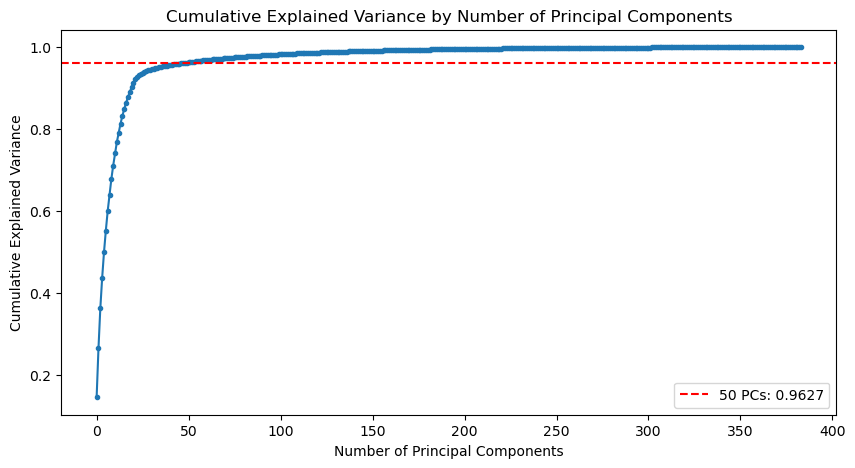

In [54]:

### To have an idea how much of the variance of embeddings are preserved by the first PCA, and
### the cumulative variance preserved by the selected PCA let's do some calculations and plot the variance vs
### number of PCAs. We calculate it for the first 50 PCAs too.

    # First we select the columns containing embeddings (under column names 0 (the 13th column) to 383)
embedding_columns = embedded_df.iloc[:, 13:]

    # Our purpose is to perform PCA with all 384 components to get full explained variance
pca_full = PCA(n_components=384)
pca_full.fit(embedding_columns)

    # To explained variance for each component we'll use this class
explained_variances = pca_full.explained_variance_ratio_

    # This is the variance explained by the first component
var_explained_pca1 = explained_variances[0]
print(f"Variance explained by the first component (pca_1): {var_explained_pca1:.4f}")

    # And, this is the cumulative variance explained up to say the 50th component
cumulative_var_50 = np.sum(explained_variances[:50])
print(f"Cumulative variance explained by the first 50 components: {cumulative_var_50:.4f}", "\n")

    # Finally, let's plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variances), marker='.')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.axhline(y=cumulative_var_50, color='r', linestyle='--', label=f"50 PCs: {cumulative_var_50:.4f}")
plt.legend()
plt.show()

In [56]:
### From the above graph it seems that the a dimension reduction using the first 50 PCAs will preserve almost all the
### variance of the PCA. They will preserve near 97% of variance of all PCAs driven from embeddings of the description.

    # First initialize PCA with the number of components we want (already defined embedding_columns)
n_components = 50
    # We already have this, only as reminder
embedding_columns = embedded_df.iloc[:, 13:]

pca_df = utils.pca_transform(n_components, embedding_columns, embedded_df)
    
pca_df.head()

,user_id,date,description,debit,credit,debit_scaled,credit_scaled,is_payroll,description_trimmed,day_of_month,day_of_week,week_of_month,month_of_year,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,4.308111,0.0,False,Insurance Payment,19,4,3,5,-1.450510,-0.301384,-1.201665,-0.334494,-0.653053,-0.482195,0.347094,-0.241905,-0.222887,-0.745096,-0.304503,-1.035676,-0.641514,-1.311075,0.422868,-0.566549,0.674620,-0.556363,0.255833,-0.447616,-0.244467,0.438771,-0.195359,0.166620,0.104149,-0.009899,0.178320,-0.049742,-0.028226,0.053406,0.041887,0.004673,-0.022421,-0.024638,0.012072,0.009310,-0.044152,-0.016296,-0.016002,0.009867,-0.017810,0.010342,-0.041986,-0.043471,-0.021428,0.035809,-0.028198,0.008672,-0.002380,0.016296
1,0,2022-05-22,ETransfer 749-55-7590,200.65,0.0,5.301562,0.0,False,ETransfer,22,7,4,5,1.712555,1.623342,1.122292,0.235226,0.738131,-0.894173,0.993633,-0.581152,-0.233862,-0.106901,-0.643323,1.942568,-0.779174,-0.724309,-0.684964,-0.304335,-0.062654,0.052155,0.226574,-0.275648,-0.285069,-0.033121,0.052930,-0.040546,0.045880,-0.015238,0.128078,0.053452,-0.019591,0.047396,0.020559,-0.021968,-0.030529,-0.016352,0.011631,-0.004872,-0.008381,0.001296,-0.019197,0.033323,-0.006629,0.039345,-0.007740,-0.008959,-0.003252,0.008085,0.022525,0.034217,-0.010133,0.010949
2,0,2022-05-30,Interest Payment 052-77-0907,51.57,0.0,3.942940,0.0,False,Interest Payment,30,1,5,5,-1.640884,1.023803,-1.477191,0.548178,-0.006489,0.498911,-0.589470,0.234510,0.028284,0.292057,0.277431,0.912462,0.627961,0.929973,-0.723267,-0.085078,0.187230,-0.187279,-0.013129,-0.625497,0.050728,0.938573,-0.229520,0.031194,0.062527,0.025715,0.220616,-0.104076,-0.044291,0.044478,0.031960,0.041242,0.012919,-0.032124,-0.008782,0.038578,0.002028,-0.026522,-0.001364,-0.002975,-0.032326,-0.011982,-0.021772,-0.020965,-0.018179,0.022876,-0.012931,0.015963,-0.003522,-0.004086
3,0,2022-06-02,Gas 095-02-5678,6.33,0.0,1.845300,0.0,False,Gas,2,4,1,6,1.444444,-1.093816,-0.236109,1.099879,1.536126,-1.053228,-0.852096,-1.609825,1.724115,-1.184929,-0.279049,-0.488196,-0.050756,0.814005,0.103735,0.194279,0.016070,-0.008464,0.211071,0.044700,-0.240441,0.152629,0.123482,0.058515,0.009445,-0.077386,0.188011,-0.015094,-0.009900,0.054993,0.050574,-0.006928,-0.037840,-0.056747,0.011101,-0.025535,-0.003665,-0.005221,-0.013063,0.022499,-0.001535,-0.010374,-0.021285,-0.025372,-0.007708,0.007470,-0.005477,0.010692,-0.006274,0.001317
4,0,2022-06-10,Shopping 020-99-8785,129.43,0.0,4.863140,0.0,False,Shopping,10,5,2,6,1.834981,-1.612268,-0.971294,-0.014389,-0.122342,0.497174,-0.841620,0.518136,-0.819572,0.789340,-0.632711,-0.300030,-0.409521,-0.120188,-0.255451,1.158363,-0.659860,-0.619993,0.543596,-0.586148,-0.260791,-0.169142,0.202567,0.138027,0.051891,-0.029578,0.227757,0.009598,-0.019327,0.010708,0.029333,0.030608,-0.003584,-0.052964,0.018142,-0.016144,0.022867,0.010191,-0.025277,0.023652,-0.010142,-0.044556,0.016205,-0.014629,0.017797,0.003636,0.002023,-0.003635,0.010189,-0.015279


In [57]:
### It is better to save it for next uses
pca_df.to_csv(file_path + 'pca_data.csv', index = False)


In [58]:
### And free the memory because embedded_df is so huge
del embedded_df

### 4. Model building and evaluation

Now that the data is cleaned and necessary features are added, we will use two models to predict the payrolls and will compare them.
Tree-based algorithms like XGBoost, Random Forest, or Gradient Boosting are less sensitive to feature scaling and multicollinearity and can handle binary variables better than linear models. These models can automatically focus on the most predictive features without overfitting to the noise.

We'll use the XGBoost classifier, which is a very efficient gradient boosting algorithm. It requires categorical variables to be encoded properly (they are so in our data) but does not require feature scaling. It's based on decision trees, which is not sensitive to the scale of features and is robust to missing values (We don't have such a problem though).

We will also apply a Logistic Regression model (if required based on XGB outcome) to the problem to compare its performance with XGBoost.

Note:
There is test data that we have not touched yet. We'll keep it as holdout data for final testing and benchmarking purposes. The idea is to split the current prepared data (made based on the train data) to train and validate our models as it consists of plenty (356800) of observations. After fine tuning our models using those datasets, we'll benchmark them against unseen data (the unseen test data).


In [62]:
### 4.1 Data preparation

    # List of features that are already replaced with more descriptive variables or are not right inputs for the model
features_todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = pca_df.drop(features_todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = pca_df['is_payroll']  # Extract the target column
    
    # Splitting the encoded dataset into training and testing sets. As we also have a hold out test data, for validation will only use 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

### 4.2 Model development

In [ ]:
### 4.2.1 XGBoost with all features + description PCAs as data

    # First initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Now, get and save the best model
best_model = utils.fit_xgb(xgb_model, X_train, y_train)

    # Save the best model
joblib.dump(best_model, 'best_xgb_model.pkl')


In [66]:
### 4.2.2 Performance of the model
y_test_probabilities, prob_table = utils.model_performance(best_model, X_train, y_train, X_test, y_test)


Training 

Accuracy: 1.0
Precision: 1.0
F1 Score: 1.0
---------------------------------------------------------------------- 

Testing 

Accuracy: 1.0
Precision: 1.0
F1 Score: 1.0
---------------------------------------------------------------------- 


Confusion Matrix: 

[[62019     0]
 [    0  9341]] 

---------------------------------------------------------------------- 

Accuracy for class 0 (validation data): 1.0
Accuracy for class 1 (validation data): 1.0
---------------------------------------------------------------------- 


Probability Table:
        Actual  Predicted  Probability_0  Probability_1
344011   False          0       0.999987       0.000013
313102    True          1       0.000354       0.999646
331982    True          1       0.000191       0.999809
18515     True          1       0.000075       0.999925
67208    False          0       0.999986       0.000014
238741   False          0       0.999987       0.000013
95903    False          0       0.999987       


****** The performance metric to optimize: ROC-AUC

Another common performance metric is the Receiver Operating Characteristic Area Under Curve (ROC_AUC).
The ROC curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds.

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to 
tell us how well a model separates the classes. In general, an AUC of 0.5 suggests no discrimination (i.e., no ability to define
payroll beyond random guessing), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9
is considered outstanding (sort of suspicious though).


 Model AUC score for the test data: 1.000000


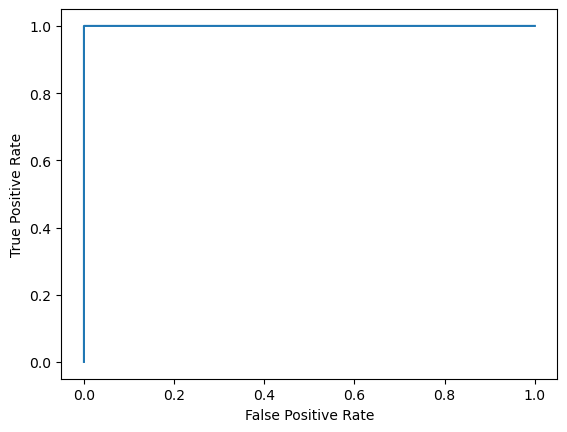

In [68]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y_test, y_test_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y_test, y_test_probabilities[:, 1]):3f}') 

### 4.3 XGBoost without PCA (with other features and description(encoded))

*** Note: The performance of the model is unexpectedly high for both training and validation. This must be due to
the strong predictive power of the 'credit' feature (as we already discussed 59% of nonzero credits belong to payrolls.
To make sure about this, one more time we train and run our model but this time without embeddings of 'description'.
We'll only encode the descriptions. The result below shows that there is a strong data leakage in 'credit' in our dataset.

In [92]:

### 4.3.1 Prepare the data
# There are 5726 unique values in description_trimmed

# Encode the categorical variables
label_encoder = LabelEncoder()
data_df['description_trimmed_encoded'] = label_encoder.fit_transform(data_df['description_trimmed'])
data_df.head()

,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled,day_of_month,day_of_week,week_of_month,month_of_year,description_trimmed,description_trimmed_encoded
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,False,4.308111,0.0,19,4,3,5,Insurance Payment,2671
1,0,2022-05-22,ETransfer 749-55-7590,200.65,0.0,False,5.301562,0.0,22,7,4,5,ETransfer,887
2,0,2022-05-30,Interest Payment 052-77-0907,51.57,0.0,False,3.942940,0.0,30,1,5,5,Interest Payment,2673
3,0,2022-06-02,Gas 095-02-5678,6.33,0.0,False,1.845300,0.0,2,4,1,6,Gas,2514
4,0,2022-06-10,Shopping 020-99-8785,129.43,0.0,False,4.863140,0.0,10,5,2,6,Shopping,5029


In [93]:
###  Data preparation (continue)

    # List of The features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = data_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = data_df['is_payroll']  # Extract the target column
    
    # Splitting the encoded dataset into training and testing sets. As we also have a hold out test data, for alidation will only use 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [94]:
### 4.3.2 fit and tune the XGBoost with simply encoded description

    # First initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Get and save the best model
best_model_encoded_descrip= utils.fit_xgb(xgb_model, X_train, y_train)

    # Save the best model
joblib.dump(best_model_encoded_descrip, 'best_xgb_model_encoded_descrip.pkl')


The model is tuned and trained in 425.70s. The best model is saved as best_xgb_model_encoder.pkl


In [95]:
### 4.3.3 Evaluate the performance of the model

y_test_probabilities, prob_table = utils.model_performance(best_model_encoded_descrip, X_train, y_train, X_test, y_test)

Training 

Accuracy: 0.9978033912556054
Precision: 0.9918452190598017
F1 Score: 0.9916470165061348
---------------------------------------------------------------------- 

Testing 

Accuracy: 0.9961883408071749
Precision: 0.9861691862335156
F1 Score: 0.9854296121705592
---------------------------------------------------------------------- 


Confusion Matrix: 

[[61890   129]
 [  143  9198]] 

---------------------------------------------------------------------- 

Accuracy for class 0 (validation data): 0.998
Accuracy for class 1 (validation data): 0.985
---------------------------------------------------------------------- 


Probability Table:
        Actual  Predicted  Probability_0  Probability_1
344011   False          0       0.999992       0.000008
313102    True          1       0.000018       0.999982
331982    True          1       0.010247       0.989753
18515     True          1       0.000009       0.999991
67208    False          0       0.999998       0.000002
238741   

 Model AUC score for the test data: 0.999907


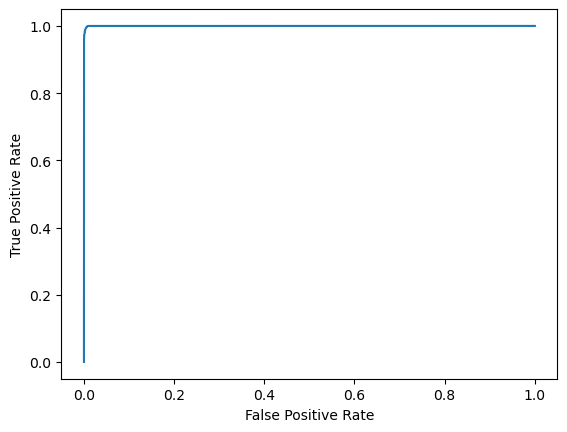

In [96]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y_test, y_test_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y_test, y_test_probabilities[:, 1]):3f}') 

4.3.4 The most important features

To define the features that are of the greatest impact or influence on the model's predictions we use the built in 
'feature_importance_' of XGBoost classifier. For tree-based models the importance is usually derived from how often
a feature is used to split the data and how much these splits improve the model's accuracy.

In [115]:

utils.feature_importance(best_model_encoded_descrip, X_train)

The most important features of the data (sorted descendingly):

                       Feature  Importance
0                credit_scaled    0.958492
1  description_trimmed_encoded    0.024407
2                month_of_year    0.008226
3                  day_of_week    0.005751
4                 day_of_month    0.003124
5                 debit_scaled    0.000000
6                week_of_month    0.000000


### 4.4 XGBoost without description or description PCAs (with other features and credit)


In [125]:
###  4.4.1 Data preparation

    # List of the features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'description_trimmed_encoded', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = data_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = data_df['is_payroll']  # Extract the target column
    
    # Splitting the encoded dataset into training and testing sets. As we also have a hold out test data, for validation will only use 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [126]:
### 4.4.2 fit and tune the XGBoost with simply encoded description

    # First initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Get and save the best model
best_model_no_descrip= utils.fit_xgb(xgb_model, X_train, y_train)

    # Save the best model
joblib.dump(best_model_no_descrip, 'best_xgb_model_nodescrip.pkl')

The model is tuned and trained in 420.09s.


['best_xgb_model_nodescrip.pkl']

In [130]:
### 4.4.3 Evaluate the performance of the model

y_test_probabilities, prob_table = utils.model_performance(best_model_no_descrip, X_train, y_train, X_test, y_test)

Training 

Accuracy: 0.9913922365470852
Precision: 0.9432455652701268
F1 Score: 0.9681376680974673
---------------------------------------------------------------------- 

Testing 

Accuracy: 0.9901485426008969
Precision: 0.9373228027541515
F1 Score: 0.9634178071499193
---------------------------------------------------------------------- 


Confusion Matrix: 

[[61400   619]
 [   84  9257]] 

---------------------------------------------------------------------- 

Accuracy for class 0 (validation data): 0.99
Accuracy for class 1 (validation data): 0.991
---------------------------------------------------------------------- 


Probability Table:
        Actual  Predicted  Probability_0  Probability_1
344011   False          0       0.999994   6.201566e-06
313102    True          1       0.000013   9.999868e-01
331982    True          1       0.378800   6.212000e-01
18515     True          1       0.000006   9.999940e-01
67208    False          0       0.999996   3.636707e-06
238741   F

### 4.5 Model with all features + PCA but without 'debit' and 'credit'

It is clear that 'credit' has a lot of data leakage, so, to see how our PCAs do in the model, this time we'll fit and train our model 
without 'credit' (and debit as well because when it is 0 it means credit > 0) but only with PCAs.

In [22]:
### 4.5.1 Data preparation

pca_df = pd.read_csv(file_path + 'pca_data.csv')

    # List of The features that are already replaced with more descriptive variables or are not right inputs for the model
features_todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'debit_scaled', 'credit_scaled', 
                   'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = pca_df.drop(features_todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = pca_df['is_payroll']  # Extract the target column
    
    # Splitting the encoded dataset into training and testing sets. As we also have a hold out test data, for alidation will only use 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [23]:
### 4.5.2 Fit and tune the XGBoost model without 'credit' and 'debit' but with PCAs

    # First initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Now, get and save the best model
best_model_only_pca = utils.fit_xgb(xgb_model, X_train, y_train)

    # Save the best model
joblib.dump(best_model_only_pca, 'best_xgb_model_only_pca.pkl')

The model is tuned and trained in 1560.18s.


['best_xgb_model_only_pca.pkl']

In [25]:
### 4.5.3 Performance of the model

y_test_probabilities, prob_table = utils.model_performance(best_model_only_pca, X_train, y_train, X_test, y_test)

Training 

Accuracy: 1.0
Precision: 1.0
F1 Score: 1.0
---------------------------------------------------------------------- 

Testing 

Accuracy: 1.0
Precision: 1.0
F1 Score: 1.0
---------------------------------------------------------------------- 


Confusion Matrix: 

[[62019     0]
 [    0  9341]] 

---------------------------------------------------------------------- 

Accuracy for class 0 (validation data): 1.0
Accuracy for class 1 (validation data): 1.0
---------------------------------------------------------------------- 


Probability Table:
        Actual  Predicted  Probability_0  Probability_1
344011   False          0       0.999994       0.000006
313102    True          1       0.000012       0.999988
331982    True          1       0.000008       0.999992
18515     True          1       0.000013       0.999987
67208    False          0       0.999995       0.000005
238741   False          0       0.999997       0.000003
95903    False          0       0.999992       

In [27]:
utils.feature_importance(best_model_only_pca, X_train)

The most important features of the data (sorted descendingly):

          Feature    Importance
0           pca_2  3.077546e-01
1          pca_25  2.525516e-01
2          pca_23  1.781690e-01
3          pca_49  9.696310e-02
4           pca_5  2.684275e-02
5          pca_33  2.099639e-02
6          pca_47  1.876273e-02
7          pca_42  1.788200e-02
8          pca_50  1.615575e-02
9          pca_40  1.564698e-02
10         pca_39  8.450573e-03
11         pca_43  8.215031e-03
12         pca_24  6.734722e-03
13         pca_29  4.264981e-03
14          pca_3  3.781809e-03
15         pca_32  3.222430e-03
16         pca_30  3.204817e-03
17         pca_31  3.051779e-03
18         pca_36  1.693433e-03
19         pca_19  9.409740e-04
20         pca_18  8.362957e-04
21         pca_28  7.574857e-04
22         pca_37  7.207733e-04
23         pca_41  7.122271e-04
24          pca_1  4.969668e-04
25         pca_26  3.952845e-04
26         pca_48  2.529586e-04
27         pca_27  2.389716e-04
28      

### 4.6 Only descriptions (encoded) and other features, No credit, debit, PCA

As we saw, PCAs are the most important features in the model. The performance is still too good (both class accuracies  = 1).
To measure the effect of (or data leakage in) descriptions, we'll only use that without PCAs, credit, and debit.

4.6.1 Prepare the data
To exclude PCAs we'll use the original dataframe (cleaned and feature engineered but before embeddings are added to it)
there are 5726 unique values in description_trimmed


In [57]:

# Encode the categorical variables
label_encoder = LabelEncoder()
data_df['description_trimmed_encoded'] = label_encoder.fit_transform(data_df['description_trimmed'])
# data_df.head()

,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled,day_of_month,day_of_week,week_of_month,month_of_year,description_trimmed,description_trimmed_encoded
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,False,4.308111,0.0,19,4,3,5,Insurance Payment,2671
1,0,2022-05-22,ETransfer 749-55-7590,200.65,0.0,False,5.301562,0.0,22,7,4,5,ETransfer,887
2,0,2022-05-30,Interest Payment 052-77-0907,51.57,0.0,False,3.942940,0.0,30,1,5,5,Interest Payment,2673
3,0,2022-06-02,Gas 095-02-5678,6.33,0.0,False,1.845300,0.0,2,4,1,6,Gas,2514
4,0,2022-06-10,Shopping 020-99-8785,129.43,0.0,False,4.863140,0.0,10,5,2,6,Shopping,5029


In [58]:
###  Data preparation

    # List of the features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'debit_scaled', 'credit_scaled', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = data_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = data_df['is_payroll']  # Extract the target column
    
    # Splitting the encoded dataset into training and testing sets. As we also have a hold out test data, for validation will only use 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [59]:
### 4.6.2 fit and tune XGBoost: no 'credit', no 'debit', no PCAs, with simply encoded description

    # First initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Get and save the best model
best_model_encoded_descrip_nocredit = utils.fit_xgb(xgb_model, X_train, y_train)

    # Save the best model
joblib.dump(best_model_encoded_descrip_nocredit, 'best_xgb_model_encoded_descrip_nocredit.pkl')

The model is tuned and trained in 589.50s.


['best_xgb_model_encoded_descrip_nocredit.pkl']

In [62]:
### 4.6.3 Performance of the logistic regression model

y_test_probabilities, prob_table = utils.model_performance(best_model_encoded_descrip_nocredit, X_train, y_train, X_test, y_test)

Training 

Accuracy: 0.9807490190582959
Precision: 1.0
F1 Score: 0.9210295618182601
---------------------------------------------------------------------- 

Testing 

Accuracy: 0.981179932735426
Precision: 1.0
F1 Score: 0.9225445527423727
---------------------------------------------------------------------- 


Confusion Matrix: 

[[62019     0]
 [ 1343  7998]] 

---------------------------------------------------------------------- 

Accuracy for class 0 (validation data): 1.0
Accuracy for class 1 (validation data): 0.856
---------------------------------------------------------------------- 


Probability Table:
        Actual  Predicted  Probability_0  Probability_1
344011   False          0       0.985095       0.014905
313102    True          1       0.000933       0.999067
331982    True          1       0.001397       0.998603
18515     True          1       0.000351       0.999649
67208    False          0       0.980406       0.019594
238741   False          0       0.960078  

In [63]:
feature_importance(best_model_encoded_descrip_nocredit, X_train)

The most important features of the data (sorted descendingly):

                       Feature  Importance
0  description_trimmed_encoded    0.639165
1                month_of_year    0.244892
2                  day_of_week    0.084973
3                 day_of_month    0.030970
4                week_of_month    0.000000


 Model AUC score for the test data: 0.985133


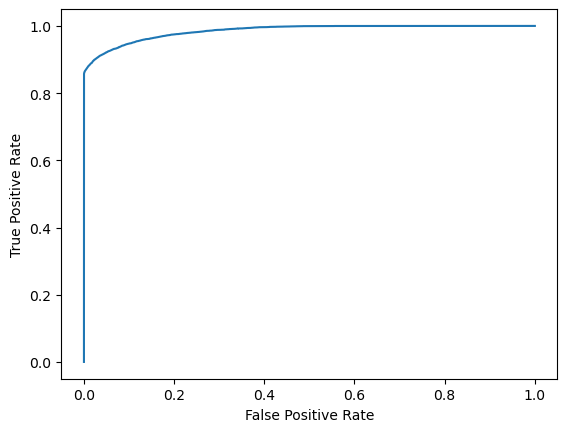

In [64]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y_test, y_test_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y_test, y_test_probabilities[:, 1]):3f}') 

### Conclusion on train data:

Credit and description both have super strong predictive power that means they are connected to is_payroll. Due to that, the predictive model easily yields a very strong performance in validation. Moreover, although deriving sentiment information from description boosts the performance of the model, it is overshadowed by the inherent unexpected bond between named input variables with the output variable.


### 5. Test the model tarined without description embeddings (PCAs) on Test Data 

We will apply two trained models on the test data:
1. XGBoost with all features and encoded trimmed description (no PCA)
2. XGBoost with all features and PCAs of trimmed description


In [2]:
### 5.1 Test data Exploration (Test Data)

holdout_df = pd.read_csv(file_path + 'test.csv')
holdout_df

,user_id,date,description,debit,credit,is_payroll
0,0,5/10/2022,Investment 415-37-7082,108.73,0.00,False
1,0,5/12/2022,Investment 880-86-1441,97.42,0.00,False
2,0,5/20/2022,Insurance Payment 738-83-9555,12.43,0.00,False
3,0,5/23/2022,Investment 800-86-4423,67.70,0.00,False
4,0,5/24/2022,Groceries 114-41-3063,1.15,0.00,False
...,...,...,...,...,...,...
57945,436,4/10/2023,Transfer 790-54-5748,42.23,0.00,False
57946,436,4/14/2023,Tax Payment 556-50-2113,93.34,0.00,False
57947,436,4/22/2023,"Ors reRstaurant mse, restauarant",0.00,1096.20,True
57948,436,5/6/2023,"Ors reRstaurant mse, restauarant",0.00,974.99,True


In [3]:
holdout_df.describe()

,user_id,debit,credit
count,57950.000000,57950.000000,57950.000000
mean,214.122813,75.652492,210.743040
std,124.388817,104.737260,765.471103
min,0.000000,0.000000,0.000000
25%,107.000000,0.070000,0.000000
50%,212.000000,40.690000,0.000000
75%,322.000000,110.637500,2.590000
max,436.000000,7270.000000,65195.070000


<Axes: ylabel='Frequency'>

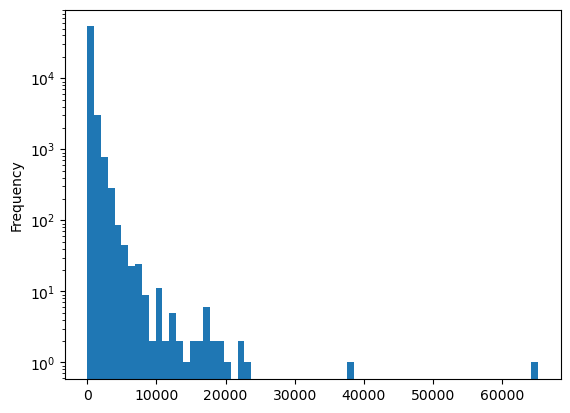

In [4]:
### Max value for credit is 65,195, so we choose 66 bins (1000 per bin)
holdout_df.credit.plot(kind = 'hist', log = True, bins = 66)

In [140]:
### If we assume 10,000 as the threshold for payroll (as an unusual amount), what persent of payrolls in test data will be above it?  
len(holdout_df[(holdout_df.is_payroll == True) & (holdout_df.credit > 10000)]) / len(holdout_df[holdout_df.is_payroll == True])

0.004030174640901106

In [5]:
### Also, it is good to know what is the rate of payroll
len(holdout_df[holdout_df.is_payroll == True]) / len(holdout_df)

0.16698878343399481

In [135]:
### Finally, we need to make sure the credit value is not a data leakage, i.e., only payrolls have a nonzero credit.
### The below result shows that the credit value (being > 0) is a too strong predictor but is not exclusive. 

share_of_payroll_of_nonzero_credit = len(holdout_df[(holdout_df.credit > 0) & \
                                         (holdout_df.is_payroll == True)]) / len(holdout_df[holdout_df.credit > 0])
print(f"{share_of_payroll_of_nonzero_credit * 100:.2f}% of nonzero credits are labelled as payroll.")

65.73% of nonzero credits are labelled as payroll.


In [ ]:
### 5.2 Data Preprocessing and cleaning

In [65]:

### handle outliers
holdout_df['debit_scaled'] = holdout_df.debit.apply(lambda x: np.log(x) if x > 0 else 0)
holdout_df['credit_scaled'] = holdout_df.credit.apply(lambda x: np.log(x) if x > 0 else 0)

In [134]:
### Now, let's remove the wrongly labled records
holdout_df, wrongly_labelled = urils.remove_wrongly_labelled_data(holdout_df)

print(f"{len(wrongly_labelled)} records where removed for being wrongly labelled.")
holdout_df.head()

171 records where removed for being wrongly labelled.


,user_id,date,description,debit,credit,is_payroll
0,0,5/10/2022,Investment 415-37-7082,108.73,0.0,False
1,0,5/12/2022,Investment 880-86-1441,97.42,0.0,False
2,0,5/20/2022,Insurance Payment 738-83-9555,12.43,0.0,False
3,0,5/23/2022,Investment 800-86-4423,67.70,0.0,False
4,0,5/24/2022,Groceries 114-41-3063,1.15,0.0,False


In [ ]:
### 5.3 Feature engineering/selection

In [67]:
### Convert date to more meaningful variables

holdout_df = utils.add_date_info(holdout_df)

In [69]:
### Trim descriptions from tailing transaction numbers
    # List to store extracted transaction numbers
trans_numbers = []

    # We'll add a new column for the trimmed description because we need the original one for further analysis later 
holdout_df['description_trimmed'] = holdout_df['description'].apply(prune_trans_number)

    # Here we check to make sure that I guess about the unique nature of transaction numbers was true.  
unique_trans_numbers = set(trans_numbers)
print(f"Total and unique transaction numbers found: {len(trans_numbers), len(unique_trans_numbers)}")

Total and unique transaction numbers found: (48273, 48272)


In [71]:
### Let's see how many unique description do we have now
holdout_df.description_trimmed.apply(lambda x: x.lower()).nunique()

1710

In [139]:
### Well, that is very good and makes sense. It is much more efficient to create embeddings from them now. But, when we checked out
### the payroll descriptions for having transaction numbers we found something interesting.

payroll_unique = holdout_df[holdout_df.is_payroll == True].description.apply(lambda x: x.lower()).nunique()
payroll_trimmed_unique = holdout_df[holdout_df.is_payroll == True].description_trimmed.apply(lambda x: x.lower()).nunique()

print("The number of payrolls with a transaction number before and after trimming in the holdout data are: ")
print(f"Before trimming = {payroll_unique}")
print(f"After trimming = {payroll_trimmed_unique}")

The number of payrolls with a transaction number before and after trimming in the holdout data are: 
Before trimming = 1690
After trimming = 1690


In [72]:
### 5.4 XGBoost without embeddings/PCA (with descriptions just encoded)

### Prepare the data
# There are 1710 unique values in description_trimmed

# Encode the categorical variables
label_encoder = LabelEncoder()
holdout_df['description_trimmed_encoded'] = label_encoder.fit_transform(holdout_df['description_trimmed'])


In [77]:

### Load the saved best model
with open('best_xgb_model_encoded_descrip.pkl', 'rb') as file:
    test_model = joblib.load(file)

In [117]:
### 5.5 Data preparation

    # List of The features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = holdout_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = holdout_df['is_payroll']  # Extract the target column


5.6 Evaluate the best model on the holdout data    AND
5.7 Do prediction and evaluate the model on test data


In [119]:

y_probabilities = utils.evaluate(test_model, X, y)

---------------------------------------------------------------------- 

Overall 

Accuracy: 0.9842105263157894
Precision: 0.9408331656268867
F1 Score: 0.9533520265103237
---------------------------------------------------------------------- 


Confusion Matrix: 

[[47685   588]
 [  327  9350]] 

---------------------------------------------------------------------- 

Accuracy - Class 0: 0.9878192778571873
Accuracy - Class 1: 0.9662085357032139


 Model AUC score for the test data: 0.997408


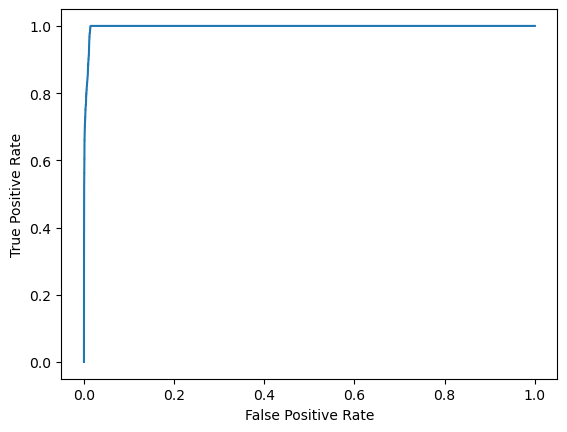

In [120]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y, y_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y, y_probabilities[:, 1]):3f}') 

### 6. Test the model tarined with description embeddings (PCAs) on Test Data 

To this end, we need to generate embeddings for the description of the test data and get their top PCAs.
We'll use the already feature engineered holdout_df but without the encoded description.

#### 6.1 Generate embeddings

We are ready to appy the embedding function (above) to our dataframe and convert the description_trimmed variable
to embeddings
We have to do it on batches otherwise we'll get insufficient memory issue. It will take about 90 min.
We won't need this variable anymore


In [85]:
# Load SBERT model and tokenizer

model_name = "sentence-transformers/all-MiniLM-L6-v2"  # This is a Lightweight and efficient model for embedding
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [87]:

holdout_df.drop(['description_trimmed_encoded'], inplace = True, axis = 1)

embeddings = utils.batch_embedding(holdout_df, tokenizer, model)

Up to row number 55000 (11.0th batch) is done!

In [90]:
## Add the embeddings as new variables to the dataframe

    # Now we can expand the embeddings into separate columns for model input
embeddings_df = pd.DataFrame(embeddings, index=holdout_df.index)
embedded_df = pd.concat([holdout_df, embeddings_df], axis=1)

    # Save the result because it will take time to generate the embedding again
embedded_df.to_csv(file_path + 'embedded_data_test.csv', index = False)


In [100]:
### 6.2 Get the PCAs

        # First we select the columns containing embeddings (under column names 0 (the 13th column) to 383)
n_components = 50
embedding_columns = embedded_df.iloc[:, 13:]

pca_df = utils.pca_transform(n_components, embedding_columns, embedded_df)

PCA transformation complete. The data now contains reduced embeddings.


In [102]:
### Let's free the memory
del embedded_df

In [103]:
### Load the savad best model fitted and tuned on the train data with PCAs
with open('best_xgb_model.pkl', 'rb') as file:
    test_model_pca = joblib.load(file)

In [121]:
###  6.3 Data preparation

    # List of The features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = pca_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = pca_df['is_payroll']  # Extract the target column

In [122]:
### 6.4 Do prediction and evaluate the model on test data
y_probabilities = utils.evaluate(test_model_pca, X, y)

---------------------------------------------------------------------- 

Overall 

Accuracy: 0.9850388265746333
Precision: 0.9894444444444445
F1 Score: 0.9535792686191572
---------------------------------------------------------------------- 


Confusion Matrix: 

[[48178    95]
 [  772  8905]] 

---------------------------------------------------------------------- 

Accuracy - Class 0: 0.9980320261844096
Accuracy - Class 1: 0.9202232096724191


 Model AUC score for the test data: 0.999675


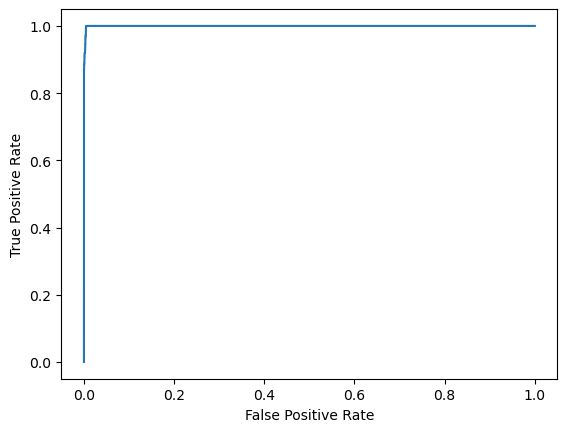

In [123]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y, y_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y, y_probabilities[:, 1]):3f}') 

### Conclusion on the test data

The same situation exist in the test data. 'credit' and 'description' are extremely strong predictors in this data set. Using sentiment analysis only improved the performance of the model very little as the basic approaches resulted in very high accuracies and ROC-AUC.

### 7. Benchmarking 

Model:
To Benchmark our XGBoost model, a logistic regression model is developed and tested for comparison here. XGBoost captures non-linear relationships and interactions, while Logistic Regression serves as a strong baseline for interpretability and performance comparison.

Data:
As the results with the given dataset are too good even without sentiment analysis (embeddings), we'll use the same feature engineered data just before adding embeddings (for sake of simplicity).

#### 7.1 Model Development - Logistic regression

##### 7.1.1 prepare the data
Data is already cleaned and feature engineered for training and validation
(if the data is not in the notebook's memory, follow the data cleaning and feature engineering of section 3 without embedding and PCA)

In [133]:

data_df.head()

,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled,day_of_month,day_of_week,week_of_month,month_of_year,description_trimmed,description_trimmed_encoded
0,0,2022-05-19,Insurance Payment 635-87-8182,74.30,0.0,False,4.308111,0.0,19,4,3,5,Insurance Payment,2671
1,0,2022-05-22,ETransfer 749-55-7590,200.65,0.0,False,5.301562,0.0,22,7,4,5,ETransfer,887
2,0,2022-05-30,Interest Payment 052-77-0907,51.57,0.0,False,3.942940,0.0,30,1,5,5,Interest Payment,2673
3,0,2022-06-02,Gas 095-02-5678,6.33,0.0,False,1.845300,0.0,2,4,1,6,Gas,2514
4,0,2022-06-10,Shopping 020-99-8785,129.43,0.0,False,4.863140,0.0,10,5,2,6,Shopping,5029


In [135]:
###  Data preparation (continue)

    # List of The features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = data_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = data_df['is_payroll']  # Extract the target column
    
    # Splitting the encoded dataset into training and testing sets. As we also have a hold out test data, for alidation will only use 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
### 7.1.2 fit and tune the Logistic Regression (LR) with simply encoded description

warnings.filterwarnings('ignore')

In [136]:

# Initialize the Logistic Regression classifier
lr_model = LogisticRegression(max_iter=2000, random_state=42)

    # Get and save the best model
best_lr_model_encoded_descrip = utils.fit_lr(lr_model, X_train, y_train)

    # Save the best model
joblib.dump(best_lr_model_encoded_descrip, 'best_lr_model_encoded_descrip.pkl')

The model is tuned and trained in 5290.02s.


['best_lr_model_encoded_descrip.pkl']

In [137]:
### 7.1.3 Evaluate the performance of the model

y_test_probabilities, prob_table = utils.model_performance(best_lr_model_encoded_descrip, X_train, y_train, X_test, y_test)

Training 

Accuracy: 0.9857938621076233
Precision: 0.9284252008802907
F1 Score: 0.9470744090737042
---------------------------------------------------------------------- 

Testing 

Accuracy: 0.9851597533632287
Precision: 0.925066721412441
F1 Score: 0.9445055808835089
---------------------------------------------------------------------- 


Confusion Matrix: 

[[61289   730]
 [  329  9012]] 

---------------------------------------------------------------------- 

Accuracy for class 0 (validation data): 0.988
Accuracy for class 1 (validation data): 0.965
---------------------------------------------------------------------- 


Probability Table:
        Actual  Predicted  Probability_0  Probability_1
344011   False      False       0.745303   2.546974e-01
313102    True       True       0.008081   9.919188e-01
331982    True      False       0.514711   4.852892e-01
18515     True       True       0.000901   9.990993e-01
67208    False      False       1.000000   3.291911e-07
238741   F

 Model AUC score for the test data: 0.998106


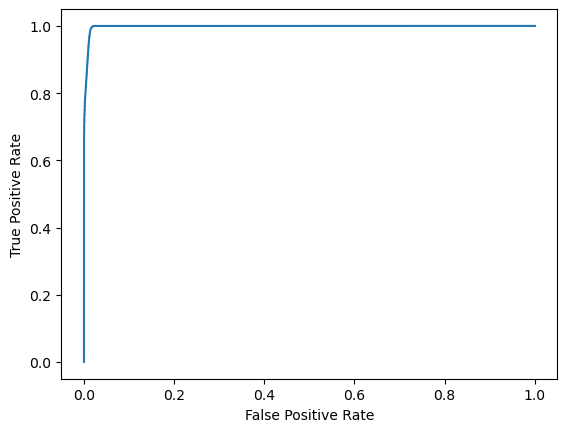

In [138]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y_test, y_test_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y_test, y_test_probabilities[:, 1]):3f}') 

#### Comparison (on train data - training and validation):

Comparing the above results with the below results for our main model (XGBoost) on the evaluation data (0.2 of train data) confirms that that model outperforms the model based on Logistic Regression.

Testing (copied from 4.3.3)

Accuracy: 0.9961883408071749
Precision: 0.9861691862335156
F1 Score: 0.9854296121705592

ROC-AUC = 0.9999

### 7.2 Test Logistic Legression model on holdout (test) data

The fitted and tuned Logistic Regression model will be tested on the holdout data that is already cleaned and feature engineered in section 5 above.

#### 7.2.1 Data preparation
(if the data is not in the notebook's memory, follow the data cleaning and feature engineering of section 5 without embedding and PCA)


In [141]:

holdout_df.head()

,user_id,date,description,debit,credit,is_payroll,debit_scaled,credit_scaled,day_of_month,day_of_week,week_of_month,month_of_year,description_trimmed,description_trimmed_encoded
0,0,2022-05-10,Investment 415-37-7082,108.73,0.0,False,4.688868,0.0,10,2,2,5,Investment,877
1,0,2022-05-12,Investment 880-86-1441,97.42,0.0,False,4.579032,0.0,12,4,2,5,Investment,877
2,0,2022-05-20,Insurance Payment 738-83-9555,12.43,0.0,False,2.520113,0.0,20,5,3,5,Insurance Payment,874
3,0,2022-05-23,Investment 800-86-4423,67.70,0.0,False,4.215086,0.0,23,1,4,5,Investment,877
4,0,2022-05-24,Groceries 114-41-3063,1.15,0.0,False,0.139762,0.0,24,2,4,5,Groceries,817


In [142]:

    # List of The features that are already replaced with more descriptive variables or are not right inputs for the model
todrop = ['user_id', 'date', 'description', 'debit', 'credit', 'description_trimmed', 'is_payroll']
    
    # Extracting valid features (X) and the target variable (y)
X = holdout_df.drop(todrop, axis=1)  # Drop unnecessary columns from the feature matrix
y = holdout_df['is_payroll']  # Extract the target column

In [143]:
### 7.2.2 Do prediction and evaluate the model on test data

y_probabilities = utils.evaluate(best_lr_model_encoded_descrip, X, y)

---------------------------------------------------------------------- 

Overall 

Accuracy: 0.9823295944779983
Precision: 0.957976077061501
F1 Score: 0.9464547165864882
---------------------------------------------------------------------- 


Confusion Matrix: 

[[47876   397]
 [  627  9050]] 

---------------------------------------------------------------------- 

Accuracy - Class 0: 0.9917759410022166
Accuracy - Class 1: 0.9352071923116668


 Model AUC score for the test data: 0.998610


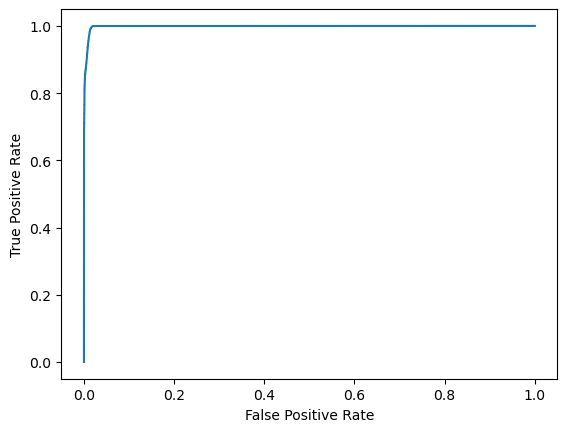

In [144]:
### Lets plot the ROC of the model and calculate its AUC.

utils.plot_roc_curve(y, y_probabilities[:, 1])
print(f'\033[1m Model AUC score for the test data: {roc_auc_score(y, y_probabilities[:, 1]):3f}') 

#### Comparison (on test data - testing with holdout data):

Comparing the above results with the results obtained by our XGBoost Model (on test data) in section 6.4 above confirms that it outperforms the Logistic Regression model on holdout data too.



In [ ]:
###################################### THE END ##########################################